In [119]:
#Imports
#Dataprep
import matplotlib.pyplot as plt
import numpy as np
from nilearn import datasets, plotting, image
from nilearn.maskers import NiftiMapsMasker
from sklearn.decomposition import FastICA
import pandas as pd
import tarfile
import gzip
#sim required
import random
import pingouin as pg
import seaborn as sns
#GNN required
import torch
import torch.nn.functional as F
from torch.nn import Linear
import torch.nn as nn
import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GraphConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.utils.data import SubsetRandomSampler
from sklearn.metrics import accuracy_score

In [120]:
def mult_chance(row,mult_lst,chance):
    if np.random.random() < chance:
        return row * mult_lst
    return row

def gen_data(mult_lst,num_rows,num_features = 10):
    # gen dataframe of random values from 0.1 to 0.2
    df = pd.DataFrame(np.random.uniform(0.1,0.2,size=(num_rows, num_features)))

    # multiply some rows by a specific list at a certain chance
    df = df.apply(lambda x: mult_chance(x,mult_lst,0.2), axis=1)
    return df

kwarg_dict = {'vmin':-1, 'vmax':1,'center':0}
fisher_dict = {'vmin':-3, 'vmax':3,'center':0}

def plot_corr_pcorr(data):
    fig, ax = plt.subplots(2,2,figsize=(11,9))
    
    corr = data.corr()
    pcorr = data.pcorr()
    fcorr = apply_fisher(corr)
    fpcorr = apply_fisher(pcorr)
    
    sns.heatmap(corr, ax=ax[0][0],**kwarg_dict)
    ax[0][0].set_title("Pearson Correlation")
    sns.heatmap(pcorr, ax=ax[0][1],**kwarg_dict)
    ax[0][1].set_title("Partial Correlation")
    
    sns.heatmap(fcorr, ax=ax[1][0],**fisher_dict)
    ax[1][0].set_title("Pearson Correlation w/ Fisher Transform")
    sns.heatmap(fpcorr, ax=ax[1][1],**fisher_dict)
    ax[1][1].set_title("Partial Correlation w/ Fisher Transform")
    
    plt.show()
    print("Pearson Positive Definite: ", positive_definite(corr))
    print("Partial Positive Definite: ", positive_definite(pcorr))
    print("Pearson w/ Fisher Transform Positive Definite: ", positive_definite(fcorr))
    print("Partial w/ Fisher Transform Positive Definite: ", positive_definite(fpcorr))

def positive_definite(data):
    # positive definite when all eigenvalues are greater than 0
    return np.all(np.linalg.eigvals(data) > 0)

def apply_fisher(data):
    numpied = data.to_numpy().copy()
    np.fill_diagonal(numpied, 0)
    return np.arctanh(numpied)

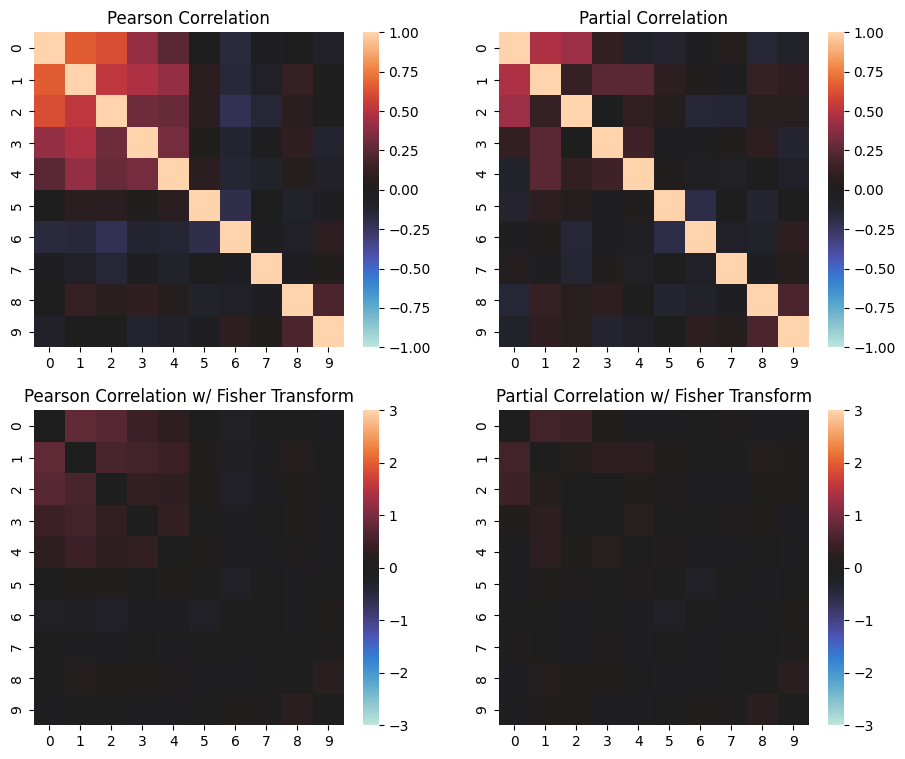

Pearson Positive Definite:  True
Partial Positive Definite:  True
Pearson w/ Fisher Transform Positive Definite:  False
Partial w/ Fisher Transform Positive Definite:  False


In [121]:
male_lst = [
        2,
        1.8,
        1.6,
        1.4,
        1.2,
        1,
        1,
        1,
        1,
        1
    ]

df = gen_data(male_lst,100)
plot_corr_pcorr(df)

In [122]:
df

,0,1,2,3,4,5,6,7,8,9
0,0.104485,0.117513,0.183335,0.115777,0.126328,0.145886,0.157212,0.135686,0.168583,0.101378
1,0.336095,0.247667,0.166914,0.202360,0.144698,0.177314,0.114810,0.176935,0.195012,0.173307
2,0.123222,0.156243,0.178078,0.153099,0.127530,0.149897,0.132209,0.196569,0.191928,0.173195
3,0.131622,0.137470,0.114193,0.168454,0.151444,0.148562,0.189742,0.135445,0.165125,0.152419
4,0.133786,0.185316,0.169793,0.114894,0.118721,0.127466,0.123225,0.102135,0.195085,0.153249
...,...,...,...,...,...,...,...,...,...,...
95,0.127045,0.111715,0.186133,0.193066,0.141229,0.196708,0.129843,0.197648,0.105331,0.169944
96,0.347568,0.212153,0.162059,0.245353,0.171157,0.176454,0.110707,0.170808,0.120280,0.106376
97,0.106366,0.191054,0.144623,0.159537,0.197122,0.170147,0.175239,0.161420,0.180325,0.132883
98,0.191209,0.191854,0.101067,0.189755,0.132392,0.141406,0.159265,0.106626,0.140528,0.145761


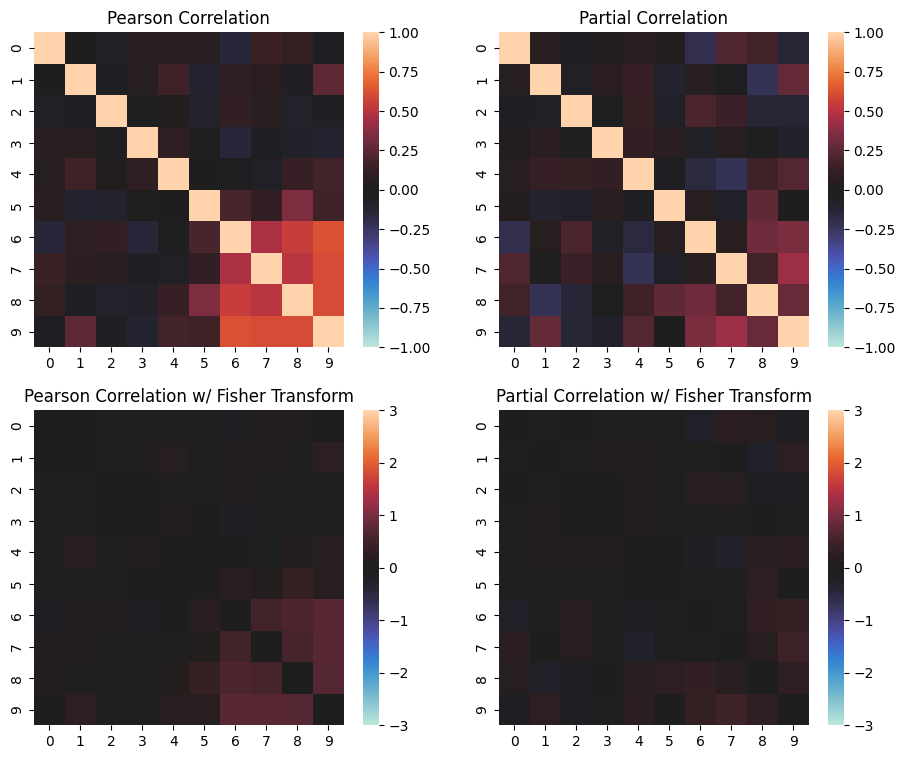

Pearson Positive Definite:  True
Partial Positive Definite:  True
Pearson w/ Fisher Transform Positive Definite:  False
Partial w/ Fisher Transform Positive Definite:  False


In [123]:
female_lst = [
        1,
        1,
        1,
        1,
        1,
        1.2,
        1.4,
        1.6,
        1.8,
        2
    ]

df = gen_data(female_lst,100)
plot_corr_pcorr(df)

In [124]:
def gen_data2(lst1,num_rows):
    df = pd.DataFrame(np.random.uniform(0.1,0.2,size=(num_rows, 10)))
    
    for lst2 in lst1:
        df = df.apply(lambda x: mult_chance(x,lst2,0.2), axis=1)    
    return df

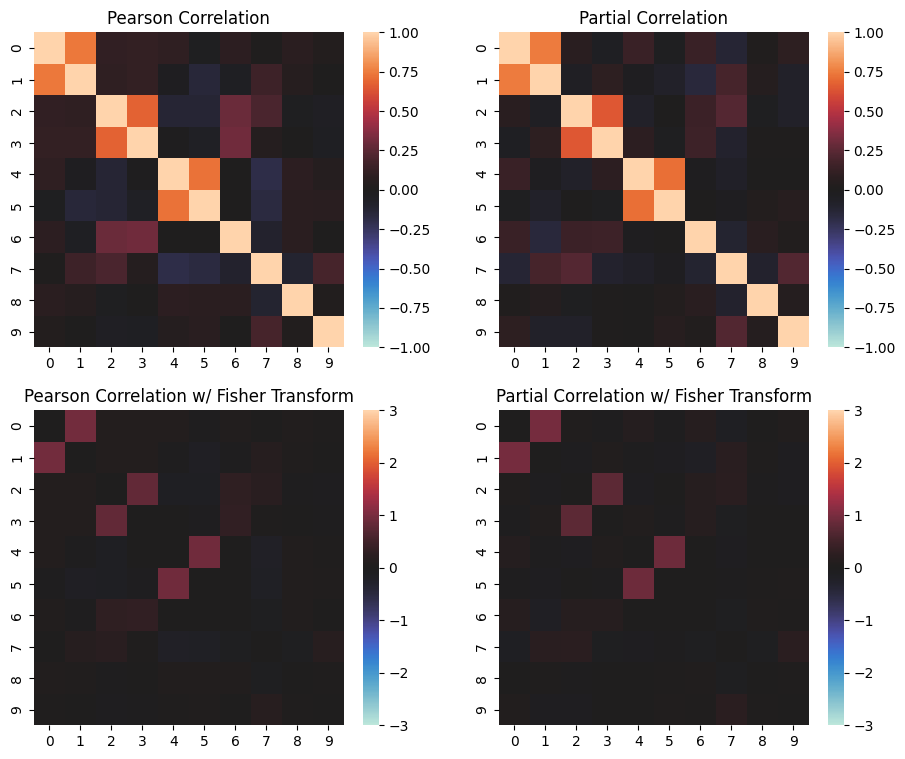

Pearson Positive Definite:  True
Partial Positive Definite:  False
Pearson w/ Fisher Transform Positive Definite:  False
Partial w/ Fisher Transform Positive Definite:  False


In [125]:
tuple_lst = [
    [2,2,1,1,1,1,1,1,1,1], # region 0 with region 1
    [1,1,2,2,1,1,1,1,1,1], # region 2 with region 3
    [1,1,1,1,2,2,1,1,1,1] # region 4 with region 5
]

df = gen_data2(tuple_lst,100)
plot_corr_pcorr(df)

In [292]:
simulated_subjects = []

while len(simulated_subjects) < 500:
    df = gen_data(male_lst, 500)
    c = df.corr()
    p = df.pcorr()
    #fc = apply_fisher(c)
    #fpc = apply_fisher(p)
    if (not positive_definite(c)) or (not positive_definite(p)):
        continue
    simulated_subjects += [('M',p)]
while len(simulated_subjects) < 1000:
    df = gen_data(female_lst, 1000)
    c = df.corr()
    p = df.pcorr()
    #fc = apply_fisher(c)
    #fpc = apply_fisher(p)
    if (not positive_definite(c)) or (not positive_definite(p)):
        continue
    simulated_subjects += [('F',p)]
random.shuffle(simulated_subjects)

In [293]:
len(simulated_subjects)

1000

In [294]:
sims = pd.DataFrame(simulated_subjects)

In [295]:
sims = sims.rename(columns={0:"Gender", 1:"netmat"})

In [296]:
sims['netmat'] = sims['netmat'].apply(lambda x: x.to_numpy())

In [297]:
sims

,Gender,netmat
0,M,"[[1.0, 0.41358447595129505, 0.2781694873406201..."
1,M,"[[1.0, 0.46905691340280786, 0.3159627955242864..."
2,M,"[[1.0, 0.474194214785042, 0.2471323535421181, ..."
3,M,"[[1.0, 0.5068351556267675, 0.26226550311048175..."
4,F,"[[1.0, -0.051239904907442686, 0.03466443086763..."
...,...,...
995,M,"[[1.0, 0.4457477836561637, 0.28313839893836096..."
996,M,"[[1.0, 0.4613933129349149, 0.3245980246137897,..."
997,F,"[[1.0, 0.02328027169890283, 0.0276815763559371..."
998,M,"[[1.0, 0.5269784528041882, 0.3095792071919142,..."


M


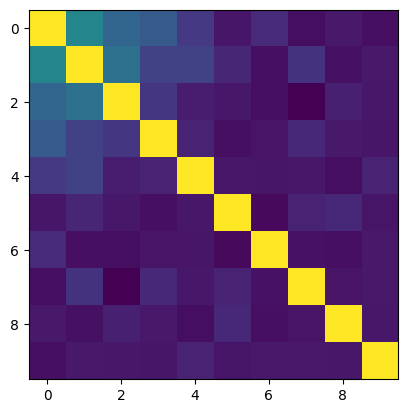

In [298]:
i = 0
print(sims.iloc[i].Gender)
plt.imshow(sims.iloc[i].netmat)

In [299]:
#Create an undirected edge index from a partial correlation matrix
def edge_gen_treshold(netmat, treshold):
    mask = np.triu(abs(netmat) > treshold, k=1) # using only bottom triangle 
    edge_i = np.transpose(np.nonzero(mask))
    return torch.tensor(edge_i.T)

In [300]:
sims['Gender'] = sims["Gender"].replace({"M":0, "F":1})
netmats = sims.netmat
labels = torch.tensor(sims.Gender.values)

In [301]:
def collate(data_list):
    graphs, labels = map(list, zip(*data_list))
    return {
        'graph': graphs,
        'label': labels
    }

# Custom dataset class
class CorrelationDataset(torch.utils.data.Dataset):
    def __init__(self, netmats, edges, labels, split_ratio=(0.8, 0.1, 0.1)):
        self.netmats = netmats
        self.labels = labels
        self.edges = edges # premade edge_index
        self.split_ratios = split_ratio
        tot = len(self.netmats)
        train_samples = int(split_ratio[0] * tot)
        val_samples = int(split_ratio[1] * tot)
        
        # Splits
        self.train_indices = list(range(0, train_samples))  # 0 - train_samples
        self.val_indices = list(range(train_samples, train_samples + val_samples))
        self.test_indices = list(range(train_samples + val_samples, tot))
        
    def __len__(self):
        return len(self.netmats)

    def __getitem__(self, idx):
        nmap = torch.tensor(self.netmats.iloc[idx]).float()
        edge_index = edge_gen_treshold(nmap, 0.1) #change edge treshhold here
        graph_data = Data(x=nmap, edge_index=edge_index)
        label = self.labels[idx]
        return graph_data, label
    
    def get_split(self, idx):
        if idx in self.train_indices:
            return 'train'
        elif idx in self.val_indices:
            return 'val'
        elif idx in self.test_indices:
            return 'test'
        else:
            raise ValueError('Index not in any split')

# Create the custom dataset
edges = None # No preset
collate_fn = collate
dataset = CorrelationDataset(netmats, edges, labels, split_ratio=(0.8, 0.1, 0.1))
train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=SubsetRandomSampler(dataset.train_indices), collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=SubsetRandomSampler(dataset.val_indices), collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=SubsetRandomSampler(dataset.test_indices), collate_fn=collate_fn)

In [302]:
tester = iter(train_loader)
next(tester)

{'graph': [Data(x=[10, 10], edge_index=[2, 6])], 'label': [tensor(1)]}

In [303]:
class simGCNten(nn.Module):
    def __init__(self,):
        super(simGCNten, self).__init__()
        self.conv1 = GCNConv(10, 20)
        self.bn1 = nn.BatchNorm1d(20)
        self.conv2 = GCNConv(20, 50)
        self.bn2 = nn.BatchNorm1d(50)
        self.classifier = Linear(50, 1)

    def forward(self, data):
        data = data['graph'][0]
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = torch.tanh(x)
        x = nn.Dropout(p=0.75)(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = torch.tanh(x)
        x = nn.Dropout(p=0.75)(x)
        x = self.classifier(x).mean(dim=0)
        x = torch.sigmoid(x)
        return x

In [304]:
model = simGCNten()

In [305]:
model

simGCNten(
  (conv1): GCNConv(10, 20)
  (bn1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GCNConv(20, 50)
  (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (classifier): Linear(in_features=50, out_features=1, bias=True)
)

In [306]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [307]:
model(next(tester))

tensor([0.5514], grad_fn=<SigmoidBackward0>)

In [308]:
def train(model, data_loader, device, loss_fn, optimizer):
    model.train()
    total_loss = 0
    num_true = 0
    num_true_guesses = 0
    for d in data_loader:
        m = d['graph'][0]
        m = m.to(device)
        label = d['label'][0]
        optimizer.zero_grad()
        out = model(d).squeeze()
        loss = loss_fn(out.float(), label.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = (out.double() > 0.5).float()
        if pred == label.double():
            num_true += 1
        if pred == 1:
            num_true_guesses += 1
    return total_loss, num_true, num_true_guesses

def eval(model, loader, device):
    model.eval()
    cor = 0
    tot = 0
    for d in loader:
        with torch.no_grad():
            out = model(d)
            pred = (out.double() > 0.5).float()
        y = d['label'][0]
        cor += (pred == y).sum()
        tot += pred.shape[0]
    return cor/tot

Epoch: 1/50, Loss: 241.09865857530167, Avg Loss: 0.301, Train: 98.88%, Validation: 98.00%, Num Correct: 702, True Guesses: 388 
Epoch: 2/50, Loss: 91.80942526780609, Avg Loss: 0.115, Train: 98.75%, Validation: 100.00%, Num Correct: 771, True Guesses: 401 
Epoch: 3/50, Loss: 103.23058910089587, Avg Loss: 0.129, Train: 98.12%, Validation: 98.00%, Num Correct: 768, True Guesses: 398 
Epoch: 4/50, Loss: 75.70221490437483, Avg Loss: 0.095, Train: 97.25%, Validation: 99.00%, Num Correct: 771, True Guesses: 401 
Epoch: 5/50, Loss: 50.08630337598194, Avg Loss: 0.063, Train: 98.50%, Validation: 98.00%, Num Correct: 782, True Guesses: 398 
Epoch: 6/50, Loss: 58.654280194654085, Avg Loss: 0.073, Train: 98.25%, Validation: 100.00%, Num Correct: 777, True Guesses: 405 
Epoch: 7/50, Loss: 62.37008355960098, Avg Loss: 0.078, Train: 99.12%, Validation: 100.00%, Num Correct: 779, True Guesses: 399 
Epoch: 8/50, Loss: 44.45571970333896, Avg Loss: 0.056, Train: 96.00%, Validation: 98.00%, Num Correct: 78

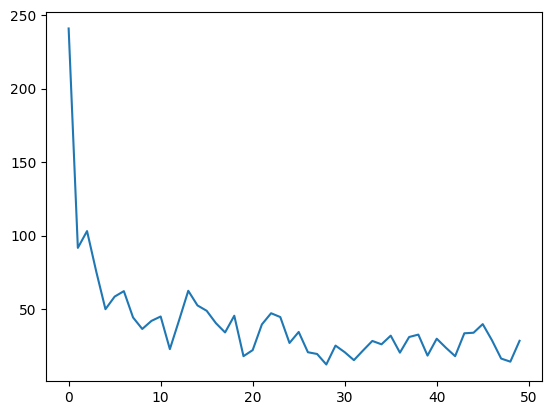

In [309]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = simGCNten().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()
losses = []

num_epochs = 50
for epoch in range(num_epochs):
    loss, num_true, num_true_guesses = train(model, train_loader, device, criterion, optimizer)
    train_results = eval(model, train_loader, device)
    val_results = eval(model, val_loader, device)
    losses.append(loss)
    avg_loss = loss / len(train_loader)
    print(f'Epoch: {epoch + 1}/{num_epochs}, '
          f'Loss: {loss}, '
          f'Avg Loss: {avg_loss:.3f}, '
          f'Train: {100 * train_results:.2f}%, '
          f'Validation: {100 * val_results:.2f}%, '
          f'Num Correct: {num_true}, '
          f'True Guesses: {num_true_guesses} ')
    
    
plt.plot(losses)
plt.show()